# **Task 3:- Email Spam Detection with Machine Learning**

**Context**
* The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research.
* It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

**Content**
* The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

* This corpus has been collected from free or free for research sources at the Internet:

* A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages..
* A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available.
* A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis.
* Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages.

### **Import libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import nltk
from nltk.corpus import stopwords
from collections import Counter

# Libraries for visualisation

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Download the stopwords dataset
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# Read the data
df = pd.read_csv("spam.csv", encoding='latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [5]:
# Dataset Summary or Information
def data_summary(data):
  print("---------------------------------------------------------------------------------")
  print("The data has {} records and {} columns.".format(data.shape[0],  data.shape[1]))
  print("---------------------------------------------------------------------------------")
  print("The Information of data:", data.info())
  print("---------------------------------------------------------------------------------")
  print("The data description:\n", data.describe())
  print("---------------------------------------------------------------------------------")
  print("The Null Count check on data:\n", data.isnull().sum())
  print("---------------------------------------------------------------------------------")

print(data_summary(df))

---------------------------------------------------------------------------------
The data has 5572 records and 5 columns.
---------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
The Information of data: None
---------------------------------------------------------------------------------
The data description:
           v1                      v2  \
count   5572                    5572   
unique     2                    5169   
top      ham  Sorry, I'll call later   
freq    4825                      30   

                               

In [6]:
# Dropping unnecessary columns from the DataFrame
columns_to_drop = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"]
df.drop(columns=columns_to_drop, inplace=True)

In [7]:
# Rename the columns "v1 and "v2" to new names
column_names = ["Category","Message"]
df.columns = column_names

In [8]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# Replace any NaN values in the DataFrame with a space

data = df.where((pd.notnull(df)), ' ')

In [10]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [11]:
# Convert the "Category" column values to numerical representation (0 for "spam" and 1 for "ham")
data.loc[data["Category"] == "spam", "Category"] = 0
data.loc[data["Category"] == "ham", "Category"] = 1

In [12]:
# Separate the feature (message) and target (category) data
X = data["Message"]
Y = data["Category"] # Target Column

In [13]:
# Split the data into training and testing sets

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 3)

In [14]:
# Shapes of the data after splitting

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((4457,), (1115,), (4457,), (1115,))

### **Vectorization**

In [15]:
# Create a TF-IDF vectorizer to convert text messages into numerical features

feature_extraction = TfidfVectorizer(min_df=1, stop_words="english", lowercase=True)

In [16]:
# Convert the training and testing text messages into numerical features using TF-IDF

X_train_features = feature_extraction.fit_transform(X_train)
X_test_features = feature_extraction.transform(X_test)

In [17]:
# Convert the target values to integers (0 and 1)

Y_train = Y_train.astype("int")
Y_test = Y_test.astype("int")

In [18]:
# Create a logistic regression model and train it on the training data

model = LogisticRegression()
model.fit(X_train_features, Y_train)

LogisticRegression()

In [19]:
# Make predictions on the training data and calculate the accuracy

prediction_on_training_data = model.predict(X_train_features)
accuracy_on_training_data = accuracy_score(Y_train, prediction_on_training_data)

In [20]:
print("Accuracy on training data:", accuracy_on_training_data)

Accuracy on training data: 0.9661207089970832


In [21]:
# Make predictions on the test data and calculate the accuracy

prediction_on_test_data = model.predict(X_test_features)
accuracy_on_test_data = accuracy_score(Y_test,prediction_on_test_data)

print("Accuracy on test data:",accuracy_on_test_data)

Accuracy on test data: 0.9623318385650225


Model is performing well on both training and test data.

In [25]:
# Test the model with some custom email messages

input_your_mail = ["Congratulations! You have won a free vacation to an exotic destination. Click the link to claim your prize now!"]
input_data_features = feature_extraction.transform(input_your_mail)
prediction = model.predict(input_data_features)
print(prediction)


# Print the prediction result

if (prediction)[0] == 1:
  print("Ham Mail")
else:
  print("Spam Mail")

[0]
Spam Mail


In [26]:
# Test the model with some custom email messages

input_your_mail = ["Meeting reminder: Tomorrow, 10 AM, conference room. See you there!"]
input_data_features = feature_extraction.transform(input_your_mail)
prediction = model.predict(input_data_features)
print(prediction)


# Print the prediction result

if (prediction)[0] == 1:
  print("Ham Mail")
else:
  print("Spam Mail")

[1]
Ham Mail


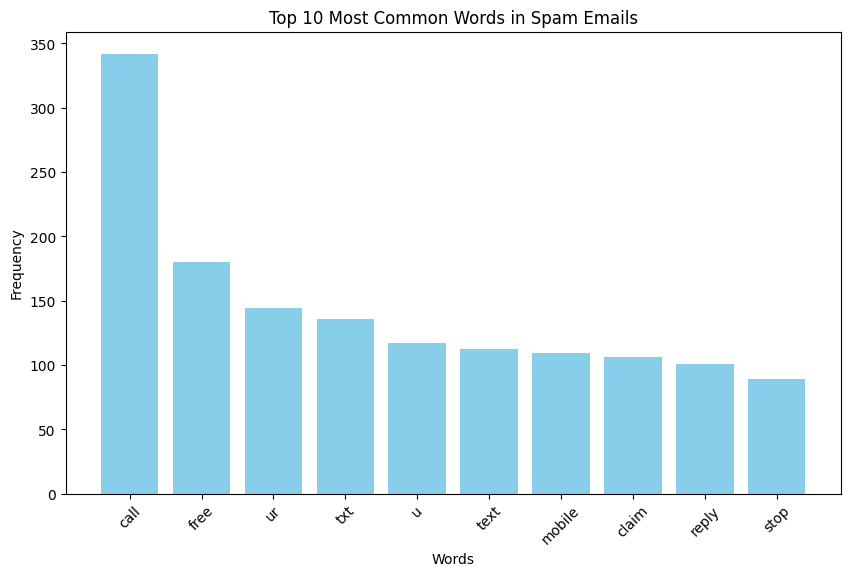

In [29]:
# Data visualization - Top 10 Most Common Words in Spam Emails

stop_words = set(stopwords.words('english'))
spam_words = " ".join(data[data['Category'] == 0]['Message']).split()
ham_words = " ".join(data[data['Category'] == 1]['Message']).split()

spam_word_freq = Counter([word.lower() for word in spam_words if word.lower() not in stop_words and word.isalpha()])

plt.figure(figsize=(10, 6))
plt.bar(*zip(*spam_word_freq.most_common(10)), color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words in Spam Emails')
plt.xticks(rotation=45)
plt.show()

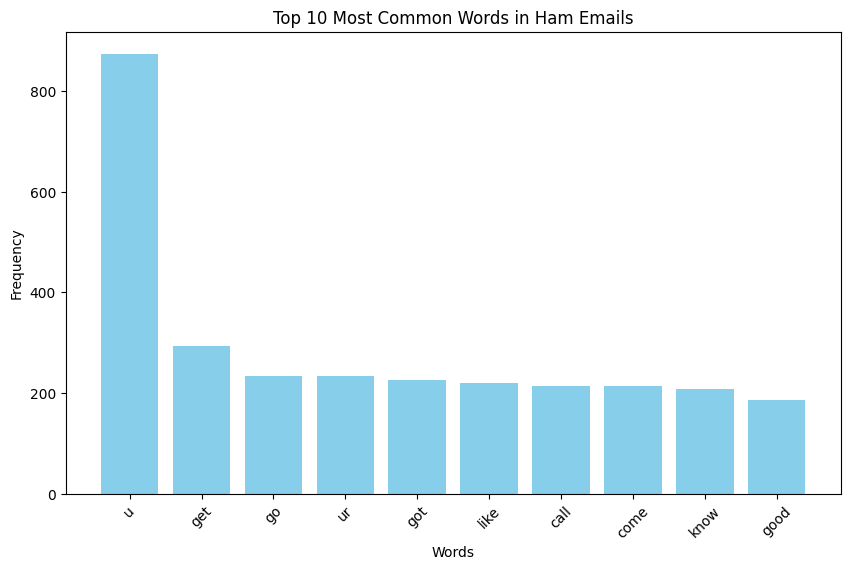

In [30]:
# Data visualization - Top 10 Most Common Words in Ham Emails

ham_word_freq = Counter([word.lower() for word in ham_words if word.lower() not in stop_words and word.isalpha()])

plt.figure(figsize=(10, 6))
plt.bar(*zip(*ham_word_freq.most_common(10)), color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words in Ham Emails')
plt.xticks(rotation=45)
plt.show()

### **Model Evaluation**

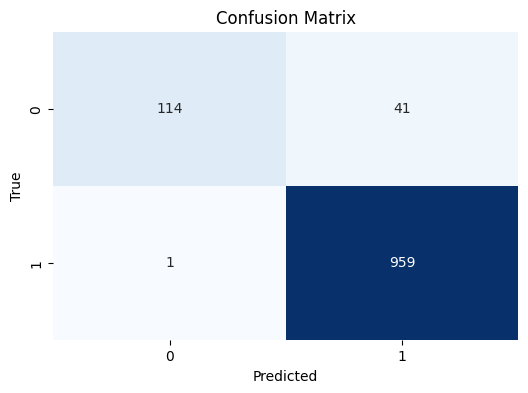

In [31]:
# Data visualization - Confusion Matrix

cm = confusion_matrix(Y_test, prediction_on_test_data)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

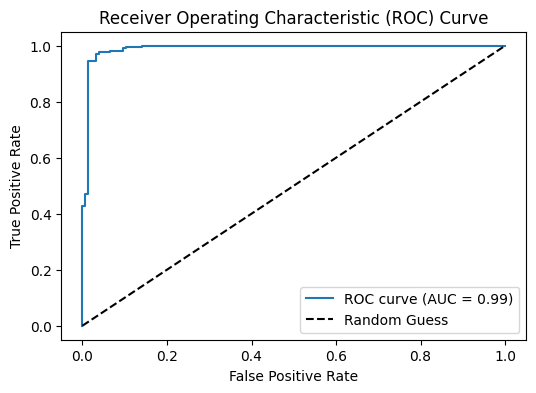

In [32]:
# Data visualization - ROC Curve

probabilities = model.predict_proba(X_test_features)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_test, probabilities)
roc_auc = roc_auc_score(Y_test, probabilities)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()